In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choisis dataset.zip dans ton explorateur de fichiers


Saving dataset.zip to dataset.zip


In [ ]:
import zipfile


zip_path = 'dataset.zip'
extract_path = 'dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
use_gpu = torch.cuda.is_available()
use_gpu

False

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365)
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet()

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('/content/dataset/dataset/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=32, shuffle=True)

# Validation
val_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('/content//dataset/dataset/validation' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=10, shuffle=False)

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial'''
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None:
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):

    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray)
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses))

  print('Finished training epoch {}'.format(epoch))
  return losses.avg  # <-- ajout ici

In [ ]:
# Move model and loss function to GPU
if use_gpu:
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 1000

In [ ]:
# Train model
train_losses = []
val_losses = []

for epoch in range(epochs):
  train(train_loader, model, criterion, optimizer, epoch)
  train_loss = train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    val_loss = validate(val_loader, model, criterion, save_images, epoch)

    train_losses.append(train_loss)
    val_losses.append(val_loss)


  if val_loss < best_losses:
    best_losses = val_loss
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1, val_loss))


Starting training epoch 0
Epoch: [0][0/4]	Time 2.164 (2.164)	Data 0.573 (0.573)	Loss 0.3382 (0.3382)	
Finished training epoch 0
Starting training epoch 0
Epoch: [0][0/4]	Time 0.486 (0.486)	Data 0.449 (0.449)	Loss 0.1219 (0.1219)	
Finished training epoch 0


<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12889 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 17252 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 15102 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12505 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color spac

Validate: [0/4]	Time 0.338 (0.338)	Loss 45592.3008 (45592.3008)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/4]	Time 0.518 (0.518)	Data 0.482 (0.482)	Loss 0.0493 (0.0493)	
Finished training epoch 1
Starting training epoch 1
Epoch: [1][0/4]	Time 0.514 (0.514)	Data 0.477 (0.477)	Loss 0.0328 (0.0328)	
Finished training epoch 1


<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 34700 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 38231 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 34657 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 36629 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color spac

Validate: [0/4]	Time 0.318 (0.318)	Loss 36.1003 (36.1003)	
Finished validation.
Starting training epoch 2
Epoch: [2][0/4]	Time 0.544 (0.544)	Data 0.507 (0.507)	Loss 0.0254 (0.0254)	
Finished training epoch 2
Starting training epoch 2
Epoch: [2][0/4]	Time 0.761 (0.761)	Data 0.722 (0.722)	Loss 0.0159 (0.0159)	
Finished training epoch 2


<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7783 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 17483 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5178 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 17345 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space 

Validate: [0/4]	Time 0.324 (0.324)	Loss 0.4447 (0.4447)	
Finished validation.
Starting training epoch 3
Epoch: [3][0/4]	Time 0.502 (0.502)	Data 0.466 (0.466)	Loss 0.0156 (0.0156)	
Finished training epoch 3
Starting training epoch 3
Epoch: [3][0/4]	Time 0.514 (0.514)	Data 0.477 (0.477)	Loss 0.0109 (0.0109)	
Finished training epoch 3


<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5140 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 276 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4966 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 67 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resul

Validate: [0/4]	Time 0.310 (0.310)	Loss 0.0168 (0.0168)	
Finished validation.
Starting training epoch 4
Epoch: [4][0/4]	Time 0.539 (0.539)	Data 0.502 (0.502)	Loss 0.0069 (0.0069)	
Finished training epoch 4
Starting training epoch 4
Epoch: [4][0/4]	Time 0.515 (0.515)	Data 0.478 (0.478)	Loss 0.0099 (0.0099)	
Finished training epoch 4


<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3629 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4018 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1108 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.449 (0.449)	Loss 0.0062 (0.0062)	
Finished validation.
Starting training epoch 5
Epoch: [5][0/4]	Time 0.612 (0.612)	Data 0.570 (0.570)	Loss 0.0074 (0.0074)	
Finished training epoch 5
Starting training epoch 5
Epoch: [5][0/4]	Time 0.505 (0.505)	Data 0.468 (0.468)	Loss 0.0039 (0.0039)	
Finished training epoch 5


<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 37 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 269 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.307 (0.307)	Loss 0.0026 (0.0026)	
Finished validation.
Starting training epoch 6
Epoch: [6][0/4]	Time 0.512 (0.512)	Data 0.473 (0.473)	Loss 0.0044 (0.0044)	
Finished training epoch 6
Starting training epoch 6
Epoch: [6][0/4]	Time 0.544 (0.544)	Data 0.508 (0.508)	Loss 0.0045 (0.0045)	
Finished training epoch 6
Validate: [0/4]	Time 0.308 (0.308)	Loss 0.0022 (0.0022)	
Finished validation.
Starting training epoch 7
Epoch: [7][0/4]	Time 0.619 (0.619)	Data 0.582 (0.582)	Loss 0.0039 (0.0039)	
Finished training epoch 7
Starting training epoch 7
Epoch: [7][0/4]	Time 0.586 (0.586)	Data 0.548 (0.548)	Loss 0.0050 (0.0050)	
Finished training epoch 7
Validate: [0/4]	Time 0.335 (0.335)	Loss 0.0021 (0.0021)	
Finished validation.
Starting training epoch 8
Epoch: [8][0/4]	Time 0.504 (0.504)	Data 0.468 (0.468)	Loss 0.0032 (0.0032)	
Finished training epoch 8
Starting training epoch 8
Epoch: [8][0/4]	Time 0.519 (0.519)	Data 0.483 (0.483)	Loss 0.0044 (0.0044)	
Finished training epoch 

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 803 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.317 (0.317)	Loss 0.0020 (0.0020)	
Finished validation.
Starting training epoch 36
Epoch: [36][0/4]	Time 0.495 (0.495)	Data 0.459 (0.459)	Loss 0.0052 (0.0052)	
Finished training epoch 36
Starting training epoch 36
Epoch: [36][0/4]	Time 0.533 (0.533)	Data 0.496 (0.496)	Loss 0.0040 (0.0040)	
Finished training epoch 36
Validate: [0/4]	Time 0.390 (0.390)	Loss 0.0019 (0.0019)	
Finished validation.
Starting training epoch 37
Epoch: [37][0/4]	Time 0.490 (0.490)	Data 0.454 (0.454)	Loss 0.0032 (0.0032)	
Finished training epoch 37
Starting training epoch 37
Epoch: [37][0/4]	Time 0.511 (0.511)	Data 0.475 (0.475)	Loss 0.0044 (0.0044)	
Finished training epoch 37
Validate: [0/4]	Time 0.337 (0.337)	Loss 0.0015 (0.0015)	
Finished validation.
Starting training epoch 38
Epoch: [38][0/4]	Time 0.512 (0.512)	Data 0.475 (0.475)	Loss 0.0041 (0.0041)	
Finished training epoch 38
Starting training epoch 38
Epoch: [38][0/4]	Time 0.529 (0.529)	Data 0.492 (0.492)	Loss 0.0036 (0.0036)	
Finishe

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 660 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.311 (0.311)	Loss 0.0015 (0.0015)	
Finished validation.
Starting training epoch 88
Epoch: [88][0/4]	Time 0.624 (0.624)	Data 0.587 (0.587)	Loss 0.0050 (0.0050)	
Finished training epoch 88
Starting training epoch 88
Epoch: [88][0/4]	Time 0.476 (0.476)	Data 0.439 (0.439)	Loss 0.0024 (0.0024)	
Finished training epoch 88
Validate: [0/4]	Time 0.314 (0.314)	Loss 0.0016 (0.0016)	
Finished validation.
Starting training epoch 89
Epoch: [89][0/4]	Time 0.474 (0.474)	Data 0.437 (0.437)	Loss 0.0024 (0.0024)	
Finished training epoch 89
Starting training epoch 89
Epoch: [89][0/4]	Time 0.515 (0.515)	Data 0.478 (0.478)	Loss 0.0033 (0.0033)	
Finished training epoch 89
Validate: [0/4]	Time 0.312 (0.312)	Loss 0.0021 (0.0021)	
Finished validation.
Starting training epoch 90
Epoch: [90][0/4]	Time 0.495 (0.495)	Data 0.459 (0.459)	Loss 0.0047 (0.0047)	
Finished training epoch 90
Starting training epoch 90
Epoch: [90][0/4]	Time 0.539 (0.539)	Data 0.501 (0.501)	Loss 0.0053 (0.0053)	
Finishe

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.305 (0.305)	Loss 0.0038 (0.0038)	
Finished validation.
Starting training epoch 389
Epoch: [389][0/4]	Time 0.517 (0.517)	Data 0.480 (0.480)	Loss 0.0026 (0.0026)	
Finished training epoch 389
Starting training epoch 389
Epoch: [389][0/4]	Time 0.522 (0.522)	Data 0.486 (0.486)	Loss 0.0025 (0.0025)	
Finished training epoch 389
Validate: [0/4]	Time 0.301 (0.301)	Loss 0.0019 (0.0019)	
Finished validation.
Starting training epoch 390
Epoch: [390][0/4]	Time 0.830 (0.830)	Data 0.793 (0.793)	Loss 0.0030 (0.0030)	
Finished training epoch 390
Starting training epoch 390
Epoch: [390][0/4]	Time 0.489 (0.489)	Data 0.453 (0.453)	Loss 0.0020 (0.0020)	
Finished training epoch 390
Validate: [0/4]	Time 0.309 (0.309)	Loss 0.0042 (0.0042)	
Finished validation.
Starting training epoch 391
Epoch: [391][0/4]	Time 0.525 (0.525)	Data 0.488 (0.488)	Loss 0.0023 (0.0023)	
Finished training epoch 391
Starting training epoch 391
Epoch: [391][0/4]	Time 0.490 (0.490)	Data 0.453 (0.453)	Loss 0.0015 

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.452 (0.452)	Loss 0.0054 (0.0054)	
Finished validation.
Starting training epoch 395
Epoch: [395][0/4]	Time 0.722 (0.722)	Data 0.683 (0.683)	Loss 0.0019 (0.0019)	
Finished training epoch 395
Starting training epoch 395
Epoch: [395][0/4]	Time 0.527 (0.527)	Data 0.490 (0.490)	Loss 0.0018 (0.0018)	
Finished training epoch 395
Validate: [0/4]	Time 0.313 (0.313)	Loss 0.0015 (0.0015)	
Finished validation.
Starting training epoch 396
Epoch: [396][0/4]	Time 0.500 (0.500)	Data 0.463 (0.463)	Loss 0.0026 (0.0026)	
Finished training epoch 396
Starting training epoch 396
Epoch: [396][0/4]	Time 0.530 (0.530)	Data 0.493 (0.493)	Loss 0.0020 (0.0020)	
Finished training epoch 396
Validate: [0/4]	Time 0.306 (0.306)	Loss 0.0016 (0.0016)	
Finished validation.
Starting training epoch 397
Epoch: [397][0/4]	Time 0.517 (0.517)	Data 0.481 (0.481)	Loss 0.0020 (0.0020)	
Finished training epoch 397
Starting training epoch 397
Epoch: [397][0/4]	Time 0.767 (0.767)	Data 0.730 (0.730)	Loss 0.0017 

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 16 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.347 (0.347)	Loss 0.0069 (0.0069)	
Finished validation.
Starting training epoch 422
Epoch: [422][0/4]	Time 0.765 (0.765)	Data 0.726 (0.726)	Loss 0.0017 (0.0017)	
Finished training epoch 422
Starting training epoch 422
Epoch: [422][0/4]	Time 0.503 (0.503)	Data 0.466 (0.466)	Loss 0.0016 (0.0016)	
Finished training epoch 422
Validate: [0/4]	Time 0.323 (0.323)	Loss 0.0026 (0.0026)	
Finished validation.
Starting training epoch 423
Epoch: [423][0/4]	Time 0.493 (0.493)	Data 0.457 (0.457)	Loss 0.0013 (0.0013)	
Finished training epoch 423
Starting training epoch 423
Epoch: [423][0/4]	Time 0.495 (0.495)	Data 0.459 (0.459)	Loss 0.0017 (0.0017)	
Finished training epoch 423
Validate: [0/4]	Time 0.306 (0.306)	Loss 0.0027 (0.0027)	
Finished validation.
Starting training epoch 424
Epoch: [424][0/4]	Time 0.498 (0.498)	Data 0.461 (0.461)	Loss 0.0016 (0.0016)	
Finished training epoch 424
Starting training epoch 424
Epoch: [424][0/4]	Time 0.743 (0.743)	Data 0.706 (0.706)	Loss 0.0020 

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.309 (0.309)	Loss 0.0076 (0.0076)	
Finished validation.
Starting training epoch 430
Epoch: [430][0/4]	Time 0.520 (0.520)	Data 0.484 (0.484)	Loss 0.0015 (0.0015)	
Finished training epoch 430
Starting training epoch 430
Epoch: [430][0/4]	Time 0.524 (0.524)	Data 0.487 (0.487)	Loss 0.0017 (0.0017)	
Finished training epoch 430
Validate: [0/4]	Time 0.307 (0.307)	Loss 0.0041 (0.0041)	
Finished validation.
Starting training epoch 431
Epoch: [431][0/4]	Time 0.491 (0.491)	Data 0.454 (0.454)	Loss 0.0019 (0.0019)	
Finished training epoch 431
Starting training epoch 431
Epoch: [431][0/4]	Time 0.482 (0.482)	Data 0.446 (0.446)	Loss 0.0013 (0.0013)	
Finished training epoch 431
Validate: [0/4]	Time 0.450 (0.450)	Loss 0.0025 (0.0025)	
Finished validation.
Starting training epoch 432
Epoch: [432][0/4]	Time 0.662 (0.662)	Data 0.626 (0.626)	Loss 0.0020 (0.0020)	
Finished training epoch 432
Starting training epoch 432
Epoch: [432][0/4]	Time 0.515 (0.515)	Data 0.478 (0.478)	Loss 0.0017 

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.308 (0.308)	Loss 0.0078 (0.0078)	
Finished validation.
Starting training epoch 439
Epoch: [439][0/4]	Time 0.514 (0.514)	Data 0.478 (0.478)	Loss 0.0016 (0.0016)	
Finished training epoch 439
Starting training epoch 439
Epoch: [439][0/4]	Time 0.546 (0.546)	Data 0.510 (0.510)	Loss 0.0019 (0.0019)	
Finished training epoch 439
Validate: [0/4]	Time 0.301 (0.301)	Loss 0.0015 (0.0015)	
Finished validation.
Starting training epoch 440
Epoch: [440][0/4]	Time 0.537 (0.537)	Data 0.499 (0.499)	Loss 0.0016 (0.0016)	
Finished training epoch 440
Starting training epoch 440
Epoch: [440][0/4]	Time 0.505 (0.505)	Data 0.469 (0.469)	Loss 0.0013 (0.0013)	
Finished training epoch 440
Validate: [0/4]	Time 0.319 (0.319)	Loss 0.0020 (0.0020)	
Finished validation.
Starting training epoch 441
Epoch: [441][0/4]	Time 0.507 (0.507)	Data 0.470 (0.470)	Loss 0.0013 (0.0013)	
Finished training epoch 441
Starting training epoch 441
Epoch: [441][0/4]	Time 0.536 (0.536)	Data 0.500 (0.500)	Loss 0.0016 

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 15 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.313 (0.313)	Loss 0.0036 (0.0036)	
Finished validation.
Starting training epoch 461
Epoch: [461][0/4]	Time 0.495 (0.495)	Data 0.458 (0.458)	Loss 0.0013 (0.0013)	
Finished training epoch 461
Starting training epoch 461
Epoch: [461][0/4]	Time 0.770 (0.770)	Data 0.731 (0.731)	Loss 0.0012 (0.0012)	
Finished training epoch 461
Validate: [0/4]	Time 0.318 (0.318)	Loss 0.0036 (0.0036)	
Finished validation.
Starting training epoch 462
Epoch: [462][0/4]	Time 0.492 (0.492)	Data 0.456 (0.456)	Loss 0.0012 (0.0012)	
Finished training epoch 462
Starting training epoch 462
Epoch: [462][0/4]	Time 0.504 (0.504)	Data 0.468 (0.468)	Loss 0.0013 (0.0013)	
Finished training epoch 462
Validate: [0/4]	Time 0.310 (0.310)	Loss 0.0016 (0.0016)	
Finished validation.
Starting training epoch 463
Epoch: [463][0/4]	Time 0.478 (0.478)	Data 0.442 (0.442)	Loss 0.0013 (0.0013)	
Finished training epoch 463
Starting training epoch 463
Epoch: [463][0/4]	Time 0.488 (0.488)	Data 0.452 (0.452)	Loss 0.0012 

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.317 (0.317)	Loss 0.0026 (0.0026)	
Finished validation.
Starting training epoch 480
Epoch: [480][0/4]	Time 0.499 (0.499)	Data 0.463 (0.463)	Loss 0.0013 (0.0013)	
Finished training epoch 480
Starting training epoch 480
Epoch: [480][0/4]	Time 0.505 (0.505)	Data 0.468 (0.468)	Loss 0.0015 (0.0015)	
Finished training epoch 480
Validate: [0/4]	Time 0.322 (0.322)	Loss 0.0040 (0.0040)	
Finished validation.
Starting training epoch 481
Epoch: [481][0/4]	Time 0.784 (0.784)	Data 0.737 (0.737)	Loss 0.0015 (0.0015)	
Finished training epoch 481
Starting training epoch 481
Epoch: [481][0/4]	Time 0.541 (0.541)	Data 0.505 (0.505)	Loss 0.0010 (0.0010)	
Finished training epoch 481
Validate: [0/4]	Time 0.302 (0.302)	Loss 0.0047 (0.0047)	
Finished validation.
Starting training epoch 482
Epoch: [482][0/4]	Time 0.504 (0.504)	Data 0.468 (0.468)	Loss 0.0011 (0.0011)	
Finished training epoch 482
Starting training epoch 482
Epoch: [482][0/4]	Time 0.498 (0.498)	Data 0.461 (0.461)	Loss 0.0011 

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.312 (0.312)	Loss 0.0034 (0.0034)	
Finished validation.
Starting training epoch 485
Epoch: [485][0/4]	Time 0.507 (0.507)	Data 0.470 (0.470)	Loss 0.0010 (0.0010)	
Finished training epoch 485
Starting training epoch 485
Epoch: [485][0/4]	Time 0.485 (0.485)	Data 0.448 (0.448)	Loss 0.0014 (0.0014)	
Finished training epoch 485
Validate: [0/4]	Time 0.365 (0.365)	Loss 0.0019 (0.0019)	
Finished validation.
Starting training epoch 486
Epoch: [486][0/4]	Time 0.767 (0.767)	Data 0.728 (0.728)	Loss 0.0012 (0.0012)	
Finished training epoch 486
Starting training epoch 486
Epoch: [486][0/4]	Time 0.510 (0.510)	Data 0.474 (0.474)	Loss 0.0014 (0.0014)	
Finished training epoch 486
Validate: [0/4]	Time 0.308 (0.308)	Loss 0.0059 (0.0059)	
Finished validation.
Starting training epoch 487
Epoch: [487][0/4]	Time 0.537 (0.537)	Data 0.501 (0.501)	Loss 0.0016 (0.0016)	
Finished training epoch 487
Starting training epoch 487
Epoch: [487][0/4]	Time 0.504 (0.504)	Data 0.466 (0.466)	Loss 0.0015 

<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 20 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))
<ipython-input-13-cc396adc7d30>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 35 negative Z values that have been clipped to zero
  color_image = lab2rgb(color_image.astype(np.float64))


Validate: [0/4]	Time 0.316 (0.316)	Loss 0.0051 (0.0051)	
Finished validation.
Starting training epoch 538
Epoch: [538][0/4]	Time 0.503 (0.503)	Data 0.467 (0.467)	Loss 0.0008 (0.0008)	
Finished training epoch 538
Starting training epoch 538
Epoch: [538][0/4]	Time 0.495 (0.495)	Data 0.459 (0.459)	Loss 0.0008 (0.0008)	
Finished training epoch 538
Validate: [0/4]	Time 0.310 (0.310)	Loss 0.0069 (0.0069)	
Finished validation.
Starting training epoch 539
Epoch: [539][0/4]	Time 0.493 (0.493)	Data 0.457 (0.457)	Loss 0.0010 (0.0010)	
Finished training epoch 539
Starting training epoch 539
Epoch: [539][0/4]	Time 0.505 (0.505)	Data 0.469 (0.469)	Loss 0.0009 (0.0009)	
Finished training epoch 539
Validate: [0/4]	Time 0.308 (0.308)	Loss 0.0032 (0.0032)	
Finished validation.
Starting training epoch 540
Epoch: [540][0/4]	Time 0.738 (0.738)	Data 0.700 (0.700)	Loss 0.0012 (0.0012)	
Finished training epoch 540
Starting training epoch 540
Epoch: [540][0/4]	Time 0.502 (0.502)	Data 0.466 (0.466)	Loss 0.0008 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbes de Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
from torchsummary import summary
from math import log10, sqrt

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365)
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet().to(device)

In [ ]:
model.load_state_dict(torch.load('/content/checkpoints/model-epoch-294-losses-0.002.pth'))

<All keys matched successfully>

In [ ]:
summary(model, input_size = (1, 128, 128), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_transformed = self.transform(img)
            img_np = np.asarray(img_transformed)  # RGB image (HxWx3)

            # Save RGB image normalized between 0 and 1
            img_rgb = img_np.astype(np.float32) / 255.0

            # Convert to Lab
            img_lab = rgb2lab(img_np)
            img_lab = (img_lab + 128) / 255

            # Extract ab channels
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()

            # Convert to grayscale
            img_gray = rgb2gray(img_np)
            img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img_gray, img_ab, torch.from_numpy(img_rgb.transpose((2, 0, 1))).float()


In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
def to_rgb(grayscale_input, ab_predicted, ground_truth_rgb):
    plt.clf()

    # Recomposer la prédiction couleur
    color_image = torch.cat((grayscale_input, ab_predicted), dim=0).numpy()
    color_image = color_image.transpose((1, 2, 0))
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
    color_image = lab2rgb(color_image.astype(np.float64))

    # Mise en forme
    grayscale_display = grayscale_input.squeeze().numpy()
    ground_truth_rgb = ground_truth_rgb.permute(1, 2, 0).numpy()  # (H, W, 3)

    # Affichage
    fig = plt.figure(figsize=(12, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Input (Grayscale)')
    ax.imshow(grayscale_display, cmap='gray')
    ax.axis("off")

    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Ground Truth (Original RGB)')
    ax.imshow(ground_truth_rgb)
    ax.axis("off")

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Predicted Value')
    ax.imshow(color_image)
    ax.axis("off")

    # Affiche la PSNR entre l'image générée et l'originale
    psnr_val = "PSNR: " + str(PSNR(ground_truth_rgb, color_image))
    print(psnr_val)


In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
test_transforms = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224)])
testset = GrayscaleImageFolder('/content/dataset/dataset/test', test_transforms)
dataloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

In [ ]:
test_transforms2 = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),
                                transforms.ToTensor()])
testset2 = datasets.ImageFolder('/content/dataset/dataset/test', transform=test_transforms2)
dataloader2 = torch.utils.data.DataLoader(testset2, batch_size=1, shuffle=True)
images, labels = next(iter(dataloader2))
image = images[0].numpy().transpose((1, 2, 0))

PSNR: 67.91344408512498
PSNR: 64.14003791487741
PSNR: 67.61542106760243
PSNR: 69.70217606566302
PSNR: 71.3092494904471
PSNR: 68.30943647595863
PSNR: 67.30644272215994
PSNR: 64.33982124005688
PSNR: 69.99009777081992
PSNR: 67.90596804466554
PSNR: 67.25314793953926
PSNR: 70.3539450736686
PSNR: 69.07102196917546
PSNR: 67.38839180461652
PSNR: 69.91932540874079
PSNR: 71.138953251994
PSNR: 66.56823764411396
PSNR: 69.39341041122273
PSNR: 68.67611425492211
PSNR: 71.60997814483028


<ipython-input-60-6327ef857e30>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 10))


PSNR: 70.67292405081952
PSNR: 67.99371853769256
PSNR: 70.1775980159133


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

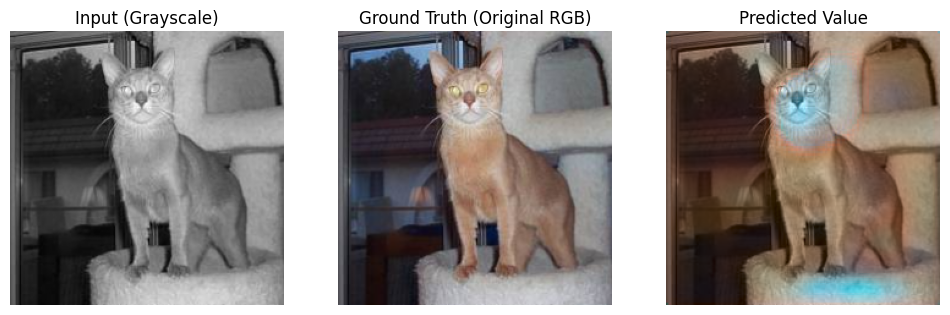

In [ ]:
for i, (input_gray, input_ab, ground_truth_rgb) in enumerate(dataloader):
    if use_gpu:
        input_gray = input_gray.cuda()

    output_ab = model(input_gray)

    for j in range(min(len(output_ab), 10)):
        to_rgb(input_gray[j].cpu(), output_ab[j].cpu().detach(), ground_truth_rgb[j].cpu())



In [ ]:
model.eval()
with torch.no_grad():
    for i, (input_gray, input_ab, target_rgb) in enumerate(val_loader):
        if i >= 5:
            break

        if use_gpu:
            input_gray = input_gray.cuda()
            input_ab = input_ab.cuda()

        # Prédiction
        output_ab = model(input_gray)

        # Appel à ta fonction d'affichage
        to_rgb(input_gray[0].cpu(),
               output_ab[0].cpu(),
               target_rgb[0].cpu())
